In [1]:
import os
import re
from collections import Counter

import anndata
import numpy as np
import pandas as pd
import scgen
import scanpy as sc
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/s

In [2]:
import logging

In [3]:
DATA_DIR = '/home/estorrs/data/single_cell_classification'
MODEL_DIR = '/home/estorrs/pollock/models'

In [ ]:
run_name = 'pbmc_bench_10x-v3'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'zheng_68k_unsorted'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Filtered_68K_PBMC_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 10000
epochs = 5
batch_size = 64

In [7]:
run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

In [8]:
%%time
# expression_df.to_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

CPU times: user 9.63 s, sys: 7.11 s, total: 16.7 s
Wall time: 16.7 s


Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
HT062B1_S1PA_AAACCCACACAAATGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCATCGGAATTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT062B1_S1PA_AAACGAACAGCTAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTCCTCGTGTTACTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT110B1_XB3_TTTGACTCAGGGTCTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=sep)
expression_df

In [ ]:
expression_df = expression_df.set_index(sample_column)
expression_df

In [9]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df

,cell_id,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
0,HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
1,HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
2,HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
3,HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
4,HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...,...
49083,HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
49084,HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
49085,HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
49086,HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [10]:
label_df = label_df.set_index('cell_id')
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
cell_id,,,,,,,,
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes


In [11]:
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [12]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 49088 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [13]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('BR_Malignant', 10137),
 ('Fibroblasts', 8305),
 ('CD4+ T-cells', 8001),
 ('CD8+ T-cells', 7080),
 ('Macrophages', 3585),
 ('B-cells', 3001),
 ('Endothelial cells', 2883),
 ('NK cells', 2053),
 ('Tregs', 1523),
 ('Plasma cells', 1445),
 ('Unknown', 808),
 ('Mast cells', 161),
 ('DC', 106)]

In [14]:
## get rid of unknowns
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

View of AnnData object with n_obs × n_vars = 48280 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, copying.


In [16]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [17]:
sc.pp.normalize_total(adata, target_sum=1e6)


In [18]:
sc.pp.log1p(adata)


In [19]:
adata.raw = adata

In [20]:
adata

AnnData object with n_obs × n_vars = 48280 × 26912 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

In [21]:
adata.X

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 4.590193],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10., min_disp=0.2)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


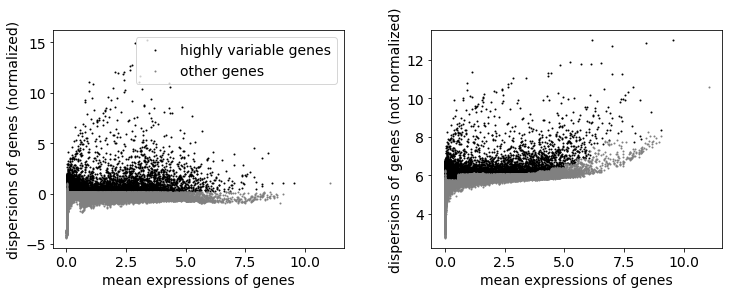

In [23]:
sc.pl.highly_variable_genes(adata)


In [24]:
np.count_nonzero(adata.var.highly_variable)

8531

In [25]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [26]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
adata

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cancer_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'organ_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'species' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'facs' as categorical


AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [27]:
sc.tl.pca(adata, svd_solver='arpack')

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/scgen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/scgen

In [29]:
sc.tl.umap(adata)

In [69]:
import random
## filter smartly
n = 500

cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > n:
        return random.sample(ls, n)
    return random.sample(ls, int(len(ls) * .8))

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

train_idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
train_idxs = np.arange(adata.shape[0])[np.isin(np.asarray(adata.obs.index), train_idxs)]
val_idxs = np.delete(np.arange(adata.shape[0]), train_idxs)

train_idxs.shape, val_idxs.shape

((5212,), (43068,))

In [70]:
# split = .2

# idxs = np.arange(adata.shape[0])
# np.random.shuffle(idxs)

# # idxs = idxs[:10000]

# train_idxs = idxs[:int(split * idxs.shape[0])]
# val_idxs = idxs[int(split * idxs.shape[0]):]

# X = np.copy(adata.X)

# X_train = X[train_idxs]
# X_val = X[val_idxs]

# y_train = adata.obs[cell_type_key][train_idxs]
# y_val = adata.obs[cell_type_key][train_idxs]
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

In [71]:
Counter(val_adata.obs[cell_type_key]).most_common()

[('BR_Malignant', 9637),
 ('Fibroblasts', 7805),
 ('CD4+ T-cells', 7501),
 ('CD8+ T-cells', 6580),
 ('Macrophages', 3085),
 ('B-cells', 2501),
 ('Endothelial cells', 2383),
 ('NK cells', 1553),
 ('Tregs', 1023),
 ('Plasma cells', 945),
 ('Mast cells', 33),
 ('DC', 22)]

In [72]:
Counter(train_adata.obs[cell_type_key]).most_common()

[('BR_Malignant', 500),
 ('Endothelial cells', 500),
 ('CD8+ T-cells', 500),
 ('NK cells', 500),
 ('Fibroblasts', 500),
 ('Macrophages', 500),
 ('Tregs', 500),
 ('CD4+ T-cells', 500),
 ('B-cells', 500),
 ('Plasma cells', 500),
 ('Mast cells', 128),
 ('DC', 84)]

In [73]:
train_adata

AnnData object with n_obs × n_vars = 5212 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [74]:
val_adata

AnnData object with n_obs × n_vars = 43068 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [75]:
scg = scgen.VAEArith(x_dimension= train_adata.shape[1], model_path="/home/estorrs/pollock/models/vae_clf_test" )

In [76]:
%%time
history = scg.train(train_data=train_adata, use_validation=True, valid_data=val_adata, n_epochs=25,
                   verbose=True)

Epoch 0: Train Loss: 1662.807947229456    Valid Loss: 37397.527320878835
Epoch 1: Train Loss: 1594.9631114064912    Valid Loss: 1707.8491215021636
Epoch 2: Train Loss: 1567.9554782443577    Valid Loss: 1682.6206405469477
Epoch 3: Train Loss: 1550.915500217014    Valid Loss: 1659.260511161492
Epoch 4: Train Loss: 1538.0277401017554    Valid Loss: 1644.7467192128688
Epoch 5: Train Loss: 1528.22280770761    Valid Loss: 1641.3685213337158
Epoch 6: Train Loss: 1520.909658172984    Valid Loss: 1642.806750125247
Epoch 7: Train Loss: 1513.2890790774497    Valid Loss: 1640.9392071238237
Epoch 8: Train Loss: 1505.7896698374807    Valid Loss: 1627.7874504911856
Epoch 9: Train Loss: 1500.1879272460938    Valid Loss: 1622.6416899613732
Epoch 10: Train Loss: 1494.122156213831    Valid Loss: 1629.2366034865822
Epoch 11: Train Loss: 1487.7071601019966    Valid Loss: 1623.877360313444
Epoch 12: Train Loss: 1481.8745878243153    Valid Loss: 1619.3075102284938


KeyboardInterrupt: 

In [77]:
train_embeddings = scg.to_latent(train_adata.X)
val_embeddings = scg.to_latent(val_adata.X)

In [78]:
encoder = OrdinalEncoder()
y_train = encoder.fit_transform(np.asarray(train_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()
y_val = encoder.transform(np.asarray(val_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()

In [79]:
clf = RandomForestClassifier()

In [80]:
%%time
clf.fit(train_embeddings, y_train)

CPU times: user 3.43 s, sys: 14 ms, total: 3.44 s
Wall time: 3.45 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [81]:
clf.score(train_embeddings, y_train)

1.0

In [82]:
clf.score(val_embeddings, y_val)

0.8673493080709576

In [83]:
from sklearn.metrics import confusion_matrix

In [84]:
preds = clf.predict(val_embeddings)

In [85]:
set(preds), set(y_val)

({0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0},
 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0})

In [90]:
c_mat = confusion_matrix(y_val, preds)
c_mat = c_mat / np.sum(c_mat, axis=1).reshape(-1, 1)
c_mat = (c_mat * 100).astype(np.int32)

In [91]:
c_mat

array([[ 94,   0,   0,   0,   1,   0,   0,   2,   0,   0,   0,   0],
       [  0,  91,   0,   0,   0,   5,   0,   0,   0,   0,   0,   0],
       [  0,   2,  72,  11,   0,   0,   0,   0,   0,   1,   0,  10],
       [  0,   0,  18,  69,   0,   0,   0,   0,   0,   6,   0,   2],
       [  0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  98,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,  97,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,  96,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0],
       [  0,   0,   1,  13,   0,   0,   0,   0,   0,  82,   0,   1],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0,   0,  95,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0,   0,   0,  90]],
      dtype=int32)

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

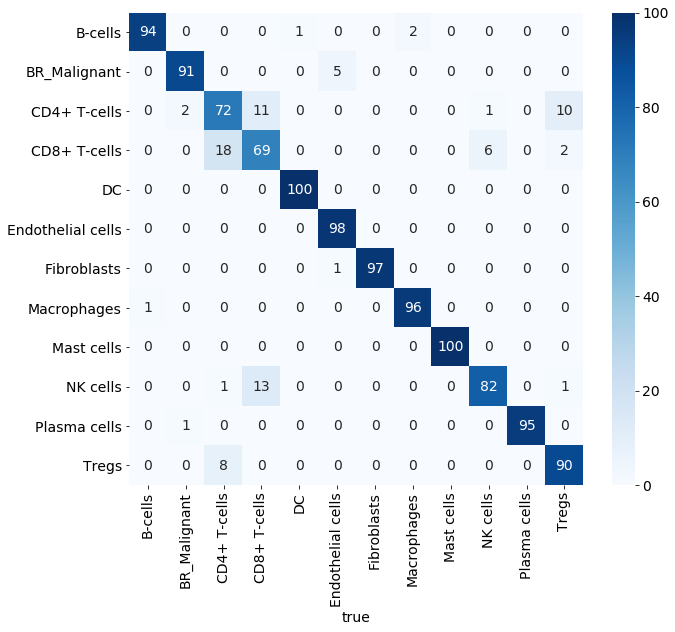

In [94]:
plt.figure(figsize=(10, 9))
sns.heatmap(c_mat, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0],
           cmap='Blues',annot=True, fmt='d')
plt.xlabel('predicted')
plt.xlabel('true')
plt.tight_layout()
plt.savefig('br_confusion_matrix.png')

In [95]:
cell_embeddings = scg.to_latent(adata.X)
cell_embeddings

array([[  9.11678   ,  -3.3155212 ,  -0.48509187, ...,   5.646352  ,
          7.686179  ,  -5.986603  ],
       [ -3.5113745 ,  -9.653051  , -10.735376  , ...,   1.2762767 ,
         -1.7670871 ,   0.2950014 ],
       [  0.46785954,  -2.1839948 ,  -4.0352154 , ...,   4.249755  ,
          0.14280133,   2.2014914 ],
       ...,
       [ -0.6787046 ,   0.7799283 ,  -6.628521  , ...,   2.0521736 ,
          0.5119117 ,   4.4025464 ],
       [ -3.8447483 ,  -3.096076  ,  -3.3843942 , ...,   2.2421675 ,
         12.200823  ,   1.6844566 ],
       [ -4.761975  ,   0.19784825, -10.506842  , ...,   1.6654556 ,
          7.329047  ,  -8.364367  ]], dtype=float32)

In [96]:
adata.obsm['scgen_embeddings'] = cell_embeddings
adata

AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'scgen_embeddings'
    varm: 'PCs'

In [97]:
predicted_cell_types = [encoder.categories_[0][int(i)] for i in clf.predict(cell_embeddings)]
adata.obs['predicted_cell_type'] = predicted_cell_types

In [98]:
import umap

In [99]:
adata.obsm['scgen_umap'] = umap.UMAP().fit_transform(adata.obsm['scgen_embeddings'])
adata

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/scgen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/

AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts', 'predicted_cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'scgen_embeddings', 'scgen_umap'
    varm: 'PCs'

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_cell_type' as categorical


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


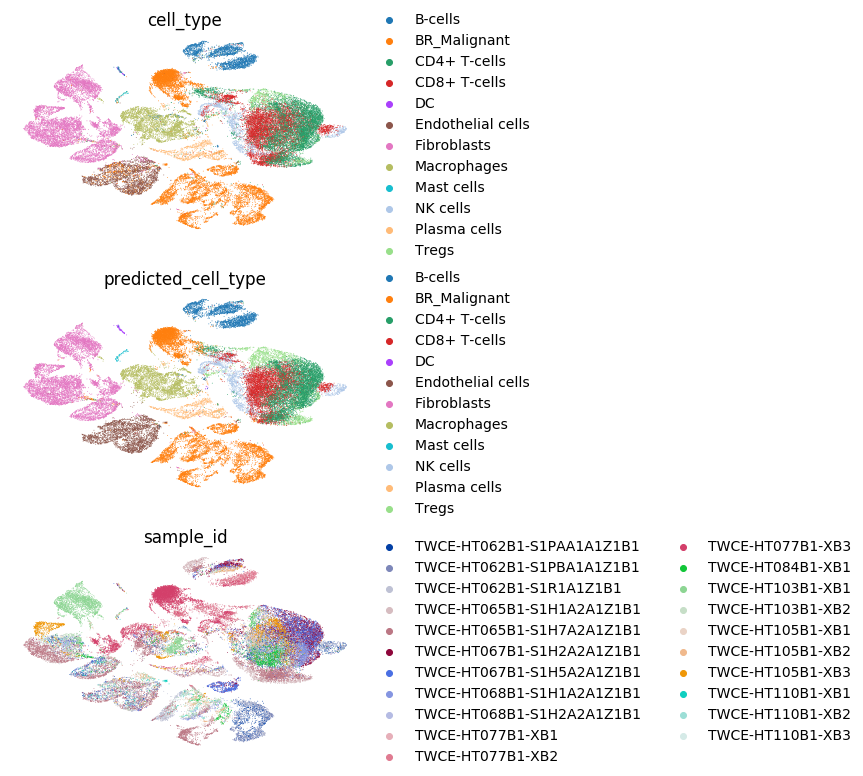

In [100]:
sc.pl.umap(adata[val_idxs], color=['cell_type', 'predicted_cell_type', 'sample_id'], frameon=False, ncols=1,
          save='_val_geneexp_umap.png')

... storing 'predicted_cell_type' as categorical


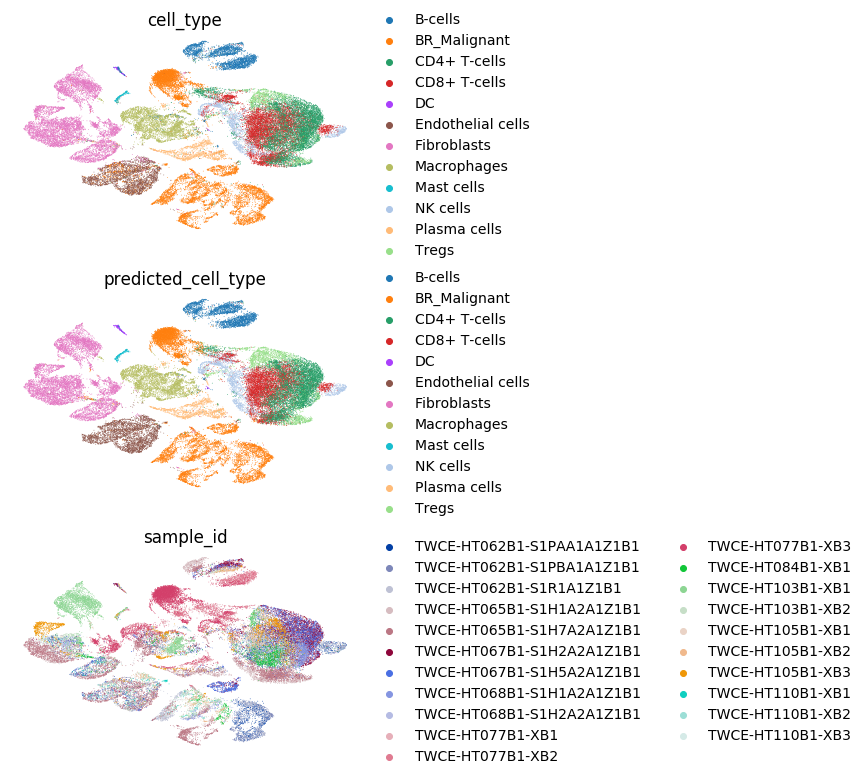

In [101]:
sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'sample_id'], frameon=False, ncols=1,
          save='_all_geneexp_umap.png')

In [102]:
adata.obs['scgen_umap1'] = adata.obsm['scgen_umap'][:, 0]
adata.obs['scgen_umap2'] = adata.obsm['scgen_umap'][:, 1]

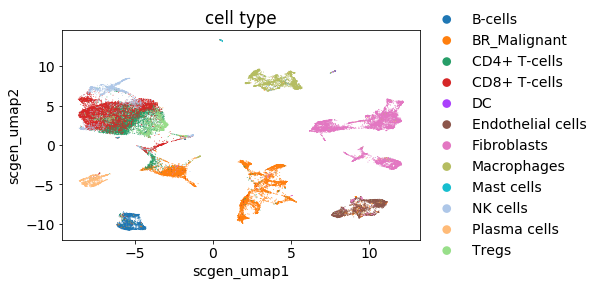

In [103]:
sc.pl.scatter(adata[val_idxs], x='scgen_umap1', y='scgen_umap2', color='cell_type',
             frameon=False, save='_val_scgen_umap_groundtruth.png')

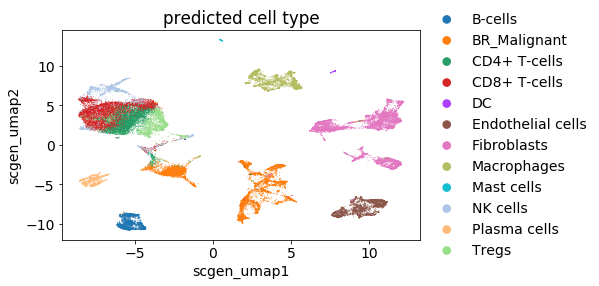

In [104]:
sc.pl.scatter(adata[val_idxs], x='scgen_umap1', y='scgen_umap2', color='predicted_cell_type',
             frameon=False, save='_val_scgen_umap_predicted.png')

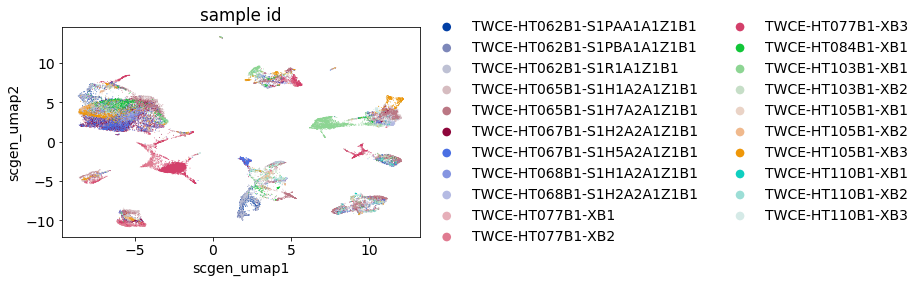

In [105]:
sc.pl.scatter(adata[val_idxs], x='scgen_umap1', y='scgen_umap2', color='sample_id',
             frameon=False, save='_val_scgen_umap_sampleid.png')

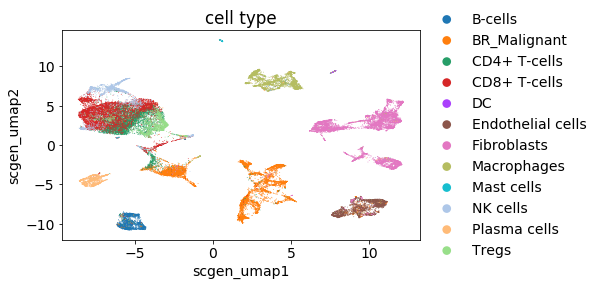

In [106]:
sc.pl.scatter(adata, x='scgen_umap1', y='scgen_umap2', color='cell_type',
             frameon=False, save='_all_scgen_umap_groundtruth.png')

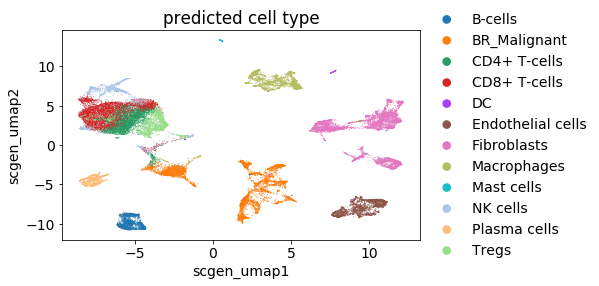

In [107]:
sc.pl.scatter(adata, x='scgen_umap1', y='scgen_umap2', color='predicted_cell_type',
             frameon=False, save='_all_scgen_umap_predicted.png')

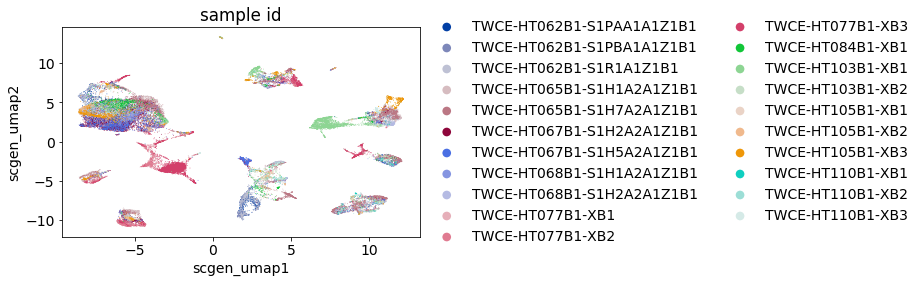

In [108]:
sc.pl.scatter(adata, x='scgen_umap1', y='scgen_umap2', color='sample_id',
             frameon=False, save='_all_scgen_umap_sampleid.png')

In [ ]:
tumor_adata = adata[adata.obs['cell_type']=='BR_Malignant'].copy()
tumor_adata

In [ ]:
sc.pl.scatter(tumor_adata, x='scgen_umap1', y='scgen_umap2', color='sample_id',
             frameon=False)

In [111]:
for k, v in Counter(adata.obs[cell_type_key]).most_common(): print(f'{k}: {v}')

BR_Malignant: 10137
Fibroblasts: 8305
CD4+ T-cells: 8001
CD8+ T-cells: 7080
Macrophages: 3585
B-cells: 3001
Endothelial cells: 2883
NK cells: 2053
Tregs: 1523
Plasma cells: 1445
Mast cells: 161
DC: 106


In [114]:
for x in sorted(set(adata.obs['sample_id'])): print(x)

TWCE-HT062B1-S1PAA1A1Z1B1
TWCE-HT062B1-S1PBA1A1Z1B1
TWCE-HT062B1-S1R1A1Z1B1
TWCE-HT065B1-S1H1A2A1Z1B1
TWCE-HT065B1-S1H7A2A1Z1B1
TWCE-HT067B1-S1H2A2A1Z1B1
TWCE-HT067B1-S1H5A2A1Z1B1
TWCE-HT068B1-S1H1A2A1Z1B1
TWCE-HT068B1-S1H2A2A1Z1B1
TWCE-HT077B1-XB1
TWCE-HT077B1-XB2
TWCE-HT077B1-XB3
TWCE-HT084B1-XB1
TWCE-HT103B1-XB1
TWCE-HT103B1-XB2
TWCE-HT105B1-XB1
TWCE-HT105B1-XB2
TWCE-HT105B1-XB3
TWCE-HT110B1-XB1
TWCE-HT110B1-XB2
TWCE-HT110B1-XB3


In [ ]:

train = sc.read("./tests/data/train_kang.h5ad",
                backup_url="https://goo.gl/33HtVh")
validation = sc.read("./tests/data/valid_kang.h5ad",
                     backup_url="https://goo.gl/8pdXiQ")

In [ ]:
train

In [ ]:
train.obs

In [ ]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]
validation_new = validation[~((validation.obs["cell_type"] == "CD4T") & (
    validation.obs["condition"] == "stimulated"))]

In [ ]:
scg = scgen.VAEArith(x_dimension= train.shape[1], model_path="/home/estorrs/pollock/models/vae_test" )

In [ ]:
scg.train(train_data=train_new, use_validation=True, valid_data=validation_new, n_epochs=10)

In [ ]:
unperturbed_cd4t = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]


In [ ]:
pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim": "stimulated"},
                          cell_type_key="cell_type",
                          condition_key="condition")

In [ ]:
pred.shape

In [ ]:
delta

In [ ]:
train_embeddings = scg.to_latent(train_new.X.toarray())
train_embeddings = scg.to_latent(train_new.X.toarray())

In [ ]:
set(train_new.X[0].toarray().flatten())